In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit



%matplotlib inline

# Creating features from the past

In [15]:
df1 = pd.read_csv('./data/1hBTCUSDT_part_1.csv')
df1 = df1[['Close']]
df1.head(10)

,Close
0,4308.83
1,4315.32
2,4324.35
3,4349.99
4,4360.69
5,4444.00
6,4460.00
7,4427.30
8,4411.00
9,4459.00


# Creating time-shifted features

#### lets create our first custom function
#### where we will collect all but the last value, then the final value
#### and calculate the % difference between the last value and the mean of earlier values

In [16]:
def percent_change(df1):
    previous_values = df1[:-1]
    last_value = df1[-1:]
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

#### lets create our second custom function
#### where we will calculate the absolute difference of each timepoint from the series mean
#### and calculate a mask for the difference that are > 3 standard deviations from zero
#### then replace these values with the median across the data

In [17]:
def replace_outliers(df1):
    absolute_differences_from_mean = np.abs(df1 - np.mean(df1))
    this_mask = absolute_differences_from_mean > (np.std(df1) * 3)
    df1[this_mask] = np.nanmedian(df1)
    return df1

#### applying our custom function and plot
#### then applying our preprocession function to the timeseries and plot results

In [18]:
df1_perc = df1.rolling(2).apply(percent_change)
df1_perc = df1_perc.apply(replace_outliers)
shifts = np.arange(1, 11).astype(int)

#### using dictionary comprehension to create name: value pairs, one pair per shift
#### then converting into a DataFrame for subsequent use
#### and plotting the first 100 samples of each

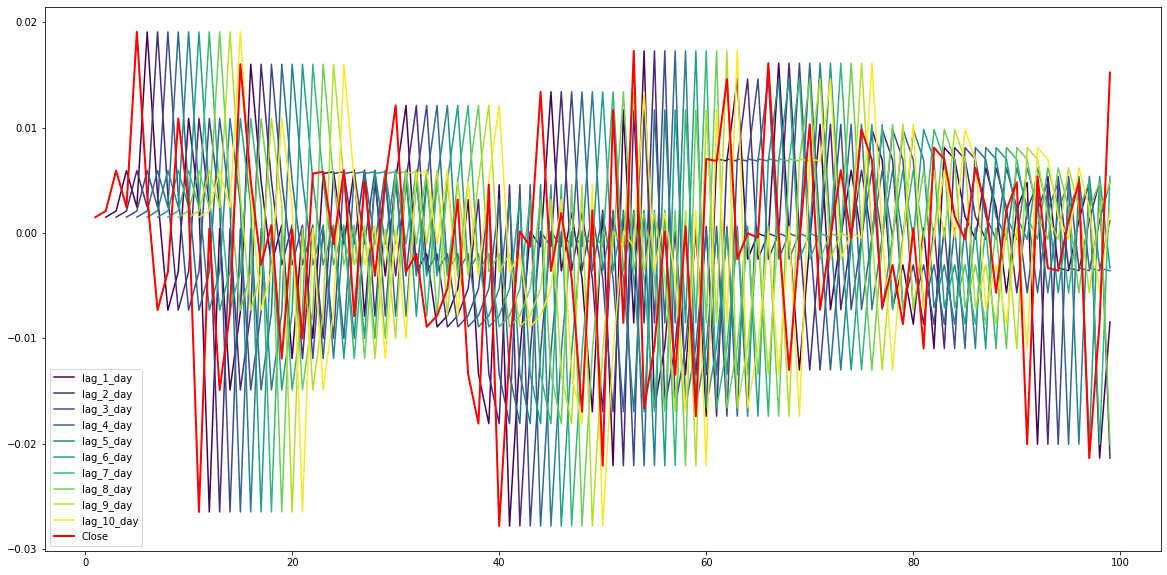

In [21]:
shifted_data = {"lag_{}_day".format(day_shift): 
                df1_perc['Close'].shift(day_shift) for day_shift in shifts}
df1_perc_shifted = pd.DataFrame(shifted_data)
ig, ax = plt.subplots(figsize=(20, 10));
df1_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis, ax=ax);
df1_perc.iloc[:100].plot(color='r', lw=2, ax=ax);
ax.legend(loc='best');

# Auto-regressive models

#### by investigating the coefficients of our model, we can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.
#### replacing missing values with the median for each column

In [160]:
from sklearn.linear_model import Ridge
X = df1_perc_shifted.fillna(np.nanmedian(df1_perc_shifted))
y = df1_perc['Close'].fillna(np.nanmedian(df1_perc['Close']))
model = Ridge()
model.fit(X, y)

Ridge()

In [23]:
def visualize_coefficients(coefs, names, ax):
    ax.bar(names, coefs);
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value');
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    plt.tight_layout();
    return ax

#### Running the function to visualize model's coefficients

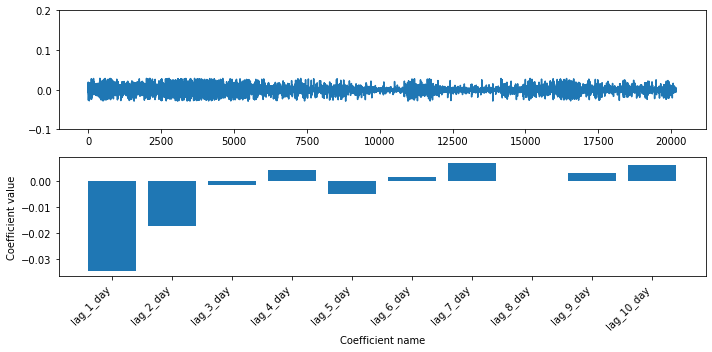

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2017-01'].plot(ax=axs[0], ylim=(-0.1, 0.2));
visualize_coefficients(model.coef_, df1_perc_shifted.columns, ax=axs[1]);

# Auto-regression with a smoother time series

In [28]:
df1_perc = df1.rolling(40).apply(percent_change)
df1_perc = df1_perc.apply(replace_outliers)
shifted_data = {"lag_{}_day".format(day_shift): 
                df1_perc['Close'].shift(day_shift) for day_shift in shifts}
df1_perc_shifted = pd.DataFrame(shifted_data)
X = df1_perc_shifted.fillna(np.nanmedian(df1_perc_shifted))
y = df1_perc['Close'].fillna(np.nanmedian(df1_perc['Close']))
model = Ridge()
model.fit(X, y)

Ridge()

#### Running the function to visualize model's coefficients

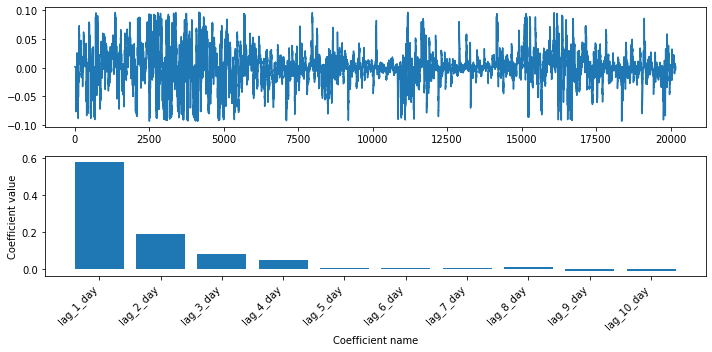

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:"2017-01"].plot(ax=axs[0])
visualize_coefficients(model.coef_, df1_perc_shifted.columns, ax=axs[1]);

#### We will make 6 different tests
#### Linear Regression (LR)
#### Lasso (LASSO)
#### Elastic Net (EN)
#### KNN (K-Nearest Neighbors)
#### CART (Classification and Regression Trees)
#### SVR (Support Vector Regression)

In [161]:
from datetime import datetime, date
from sklearn.model_selection import train_test_split
start = datetime(2017, 1, 1)
end = date.today()
df=pd.read_csv('./data/1hBTCUSDT_part_1.csv')
btc = df[df.columns[0:1]]
btc.reset_index(level=0, inplace=True)
dataset = btc.values
X = dataset[:,1].reshape(-1,1)
Y = dataset[:,0:1]
validation_size = 0.15
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [162]:
num_folds = 10
seed = 7
scoring = "r2"
#Spot-Check Algorithms
models = []
models.append((' LR ', LinearRegression()))
models.append((' LASSO ', Lasso()))
models.append((' EN ', ElasticNet()))
models.append((' KNN ', KNeighborsRegressor()))
models.append((' CART ', DecisionTreeRegressor()))
models.append((' SVR ', SVR()))

# Evaluating the model

#### evaluating each model in turn 

In [163]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    # print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 LR : 0.999999 (0.000000)
 LASSO : 0.999999 (0.000000)
 EN : 0.999999 (0.000000)
 KNN : 1.000000 (0.000000)
 CART : 1.000000 (0.000000)


/usr/local/Cellar/jupyterlab/3.0.6/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.0.6/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.0.6/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.0.6/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vect

 SVR : 0.808197 (0.004020)


#### loading data and splitting it into separate pieces
#### and picking model based on which has a lower mean error rate

In [ ]:
from pmdarima import model_selection
dа1 = pm.datasets.load_wineind()
train, test = model_selection.train_test_split(data, train_size=165)
model1 = pm.ARIMA(order=(2, 1, 1))
model2 = pm.ARIMA(order=(1, 1, 2),
                  seasonal_order=(0, 1, 1, 12),
                  suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=100, step=24, h=1)
model1_cv_scores = model_selection.cross_val_score(
    model1, train, scoring='smape', cv=cv, verbose=2)
model2_cv_scores = model_selection.cross_val_score(
    model2, train, scoring='smape', cv=cv, verbose=2)
print("Model_1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model_2 CV scores: {}".format(model2_cv_scores.tolist()))
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
errors = [m1_average_error, m2_average_error]
models = [model1, model2]
better_index = np.argmin(errors) 
print("Lowest average SMAPE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))